In [ ]:
import pandas as pd
import os

def summarize_model_results(input_csv, output_csv):
    # List of accuracy columns to process
    acc_columns = [
        "Acc_Clean_No_Attack",
        "Acc_FGSM_eps0001","Acc_FGSM_eps0002","Acc_FGSM_eps0005","Acc_FGSM_eps001",
        "Acc_FGSM_eps002","Acc_FGSM_eps003","Acc_FGSM_eps004","Acc_FGSM_eps005",
        "Acc_FGSM_eps0075","Acc_FGSM_eps01",
        "Acc_PGD_eps0001__10_steps","Acc_PGD_eps0002__10_steps","Acc_PGD_eps0005__10_steps",
        "Acc_PGD_eps001__10_steps","Acc_PGD_eps002__10_steps","Acc_PGD_eps003__10_steps",
        "Acc_PGD_eps005__10_steps","Acc_PGD_eps0075__10_steps","Acc_PGD_eps01__10_steps",
        "Acc_PGD_eps0001__20_steps","Acc_PGD_eps0002__20_steps","Acc_PGD_eps0005__20_steps",
        "Acc_PGD_eps001__20_steps","Acc_PGD_eps002__20_steps","Acc_PGD_eps003__20_steps",
        "Acc_PGD_eps005__20_steps","Acc_PGD_eps0075__20_steps","Acc_PGD_eps01__20_steps"
    ]
    
    # Read input CSV
    df = pd.read_csv(input_csv)
    
    # Number of runs per model
    group_size = 10
    num_groups = len(df) // group_size

    summary_rows = []
    for i in range(num_groups):
        group = df.iloc[i*group_size:(i+1)*group_size]
        row = {}
        row["Model"] = group["Model"].iloc[0]
        row["Epochs"] = group["last_epoch"].mean()
        for col in acc_columns:
            row[f"{col}_mean"] = group[col].mean()
            row[f"{col}_std"] = group[col].std()
        summary_rows.append(row)
    
    summary_df = pd.DataFrame(summary_rows)
    
    #. Save in directory Results
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    summary_df.to_csv(output_csv, index=False)

# Example usage:
# summarize_model_results("input_results.csv", "summary_results.csv")

In [9]:
for dataset in ["ArticularyWordRecognition", "BasicMotions", "EMOPain", "Epilepsy", "JapaneseVowels", "UWaveGestureLibrary"]:
    input_file = f"csv_results/classification/result_{dataset}.csv"
    output_file = f"Results/{dataset}.csv"
    summarize_model_results(input_file, output_file)


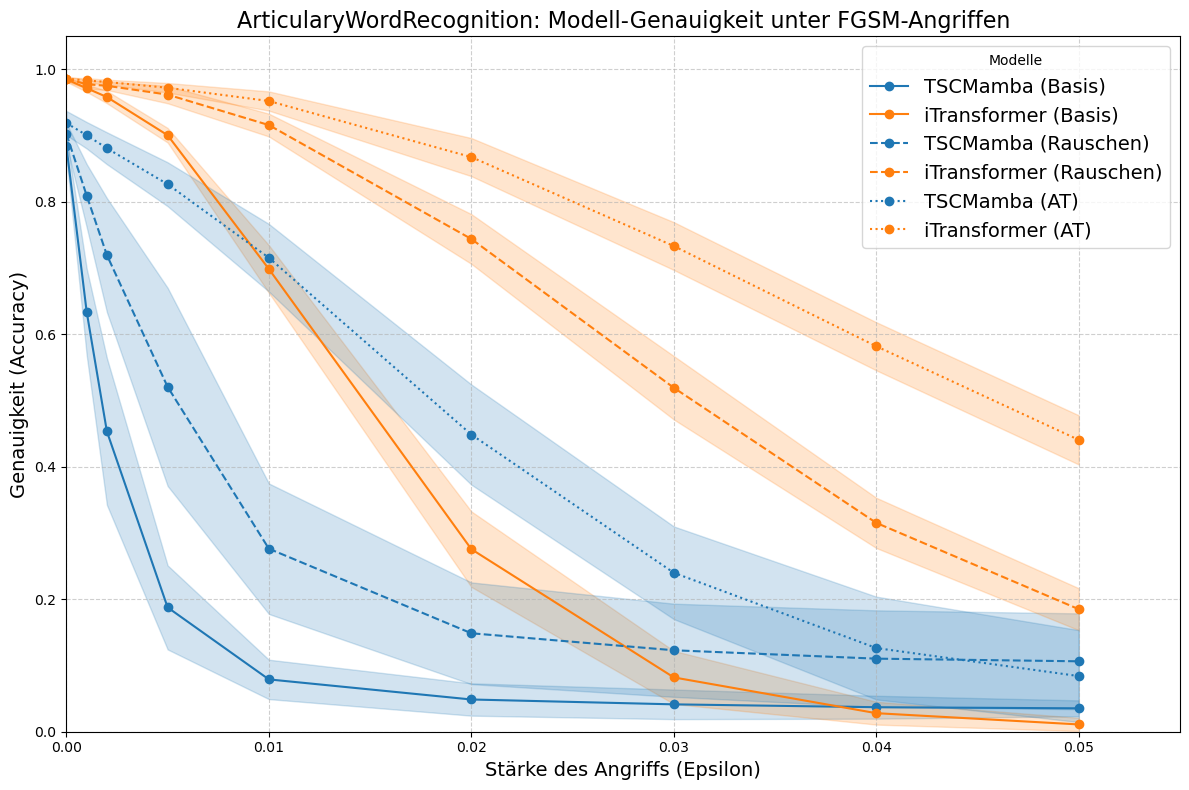

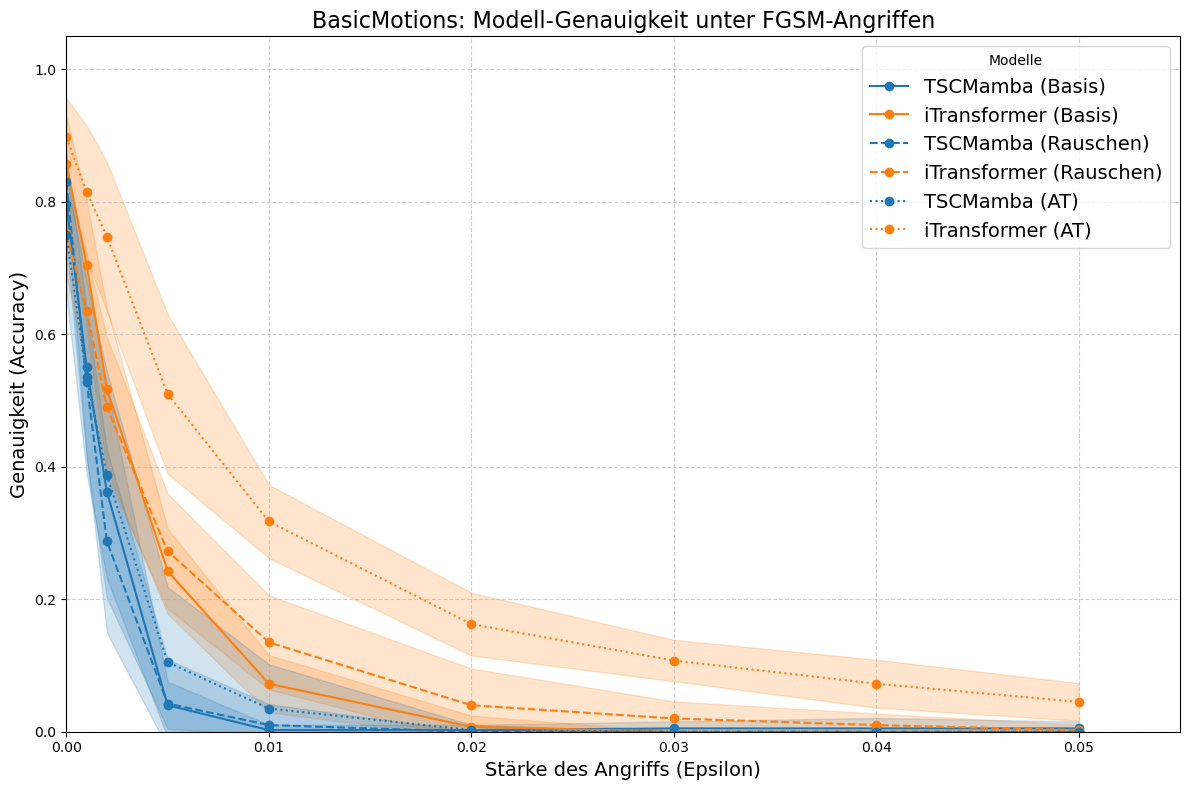

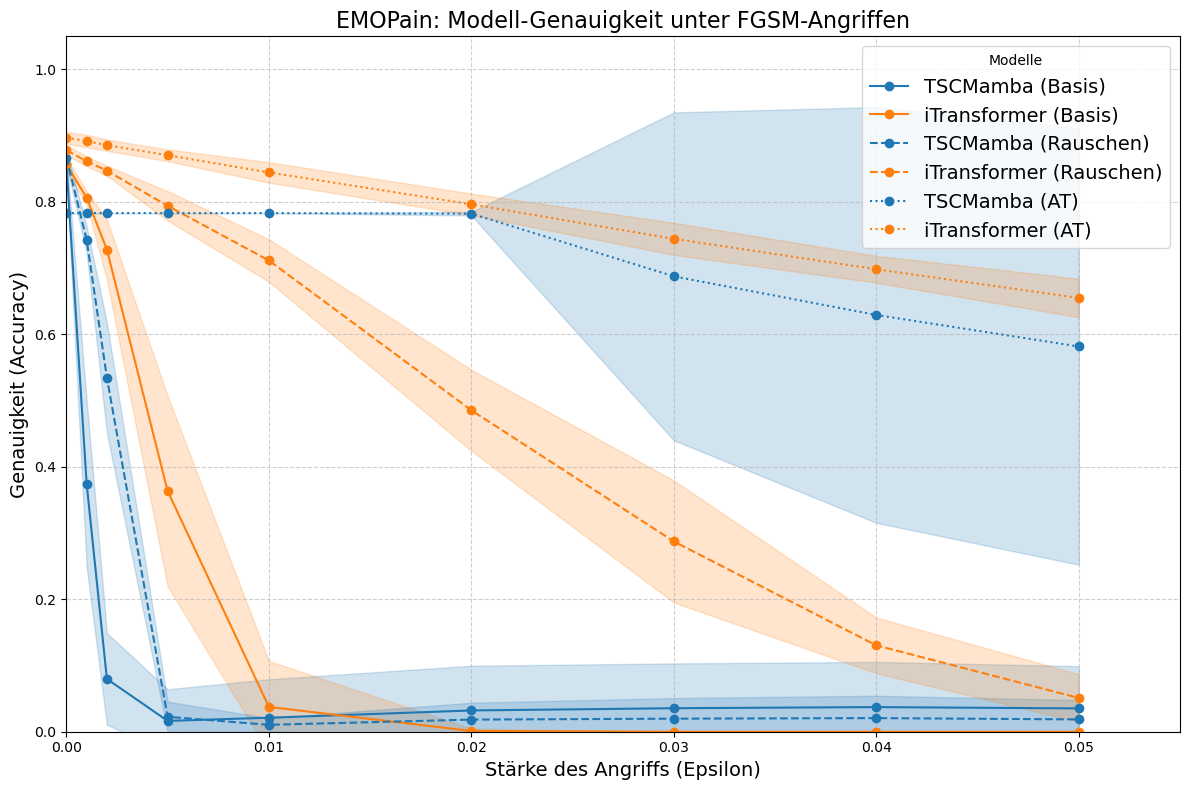

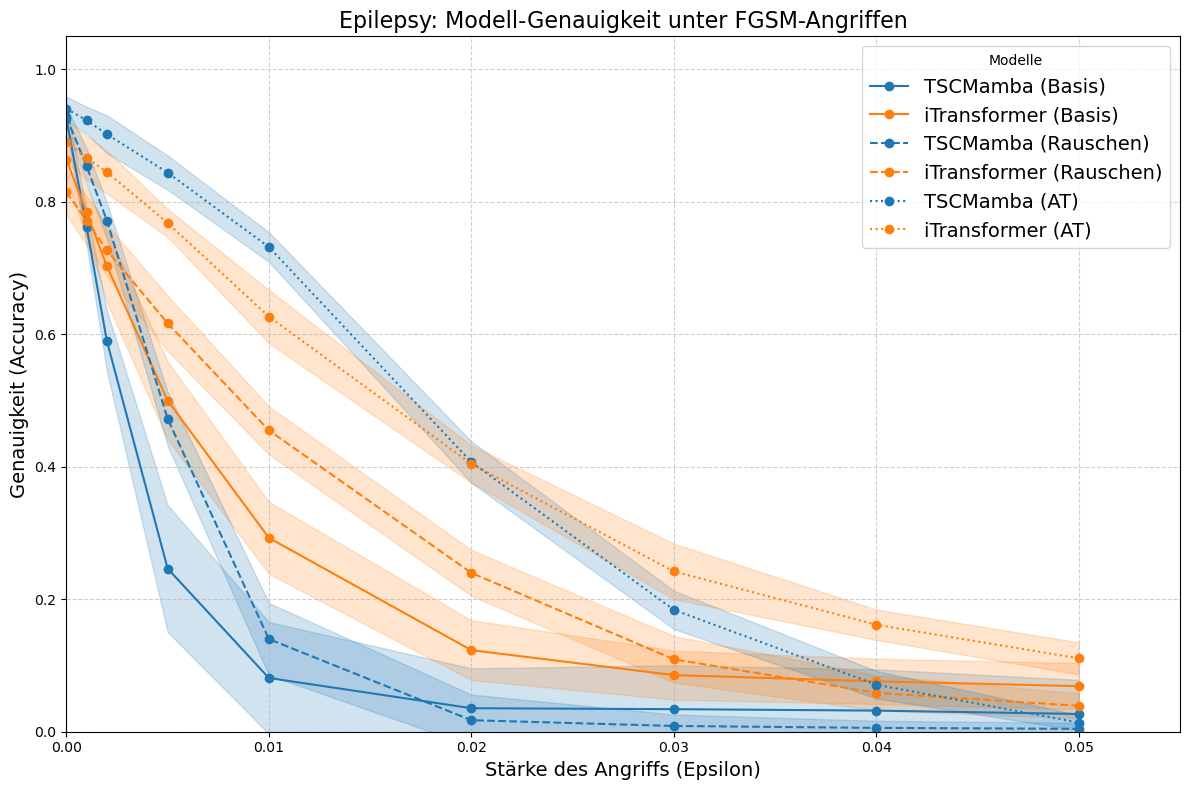

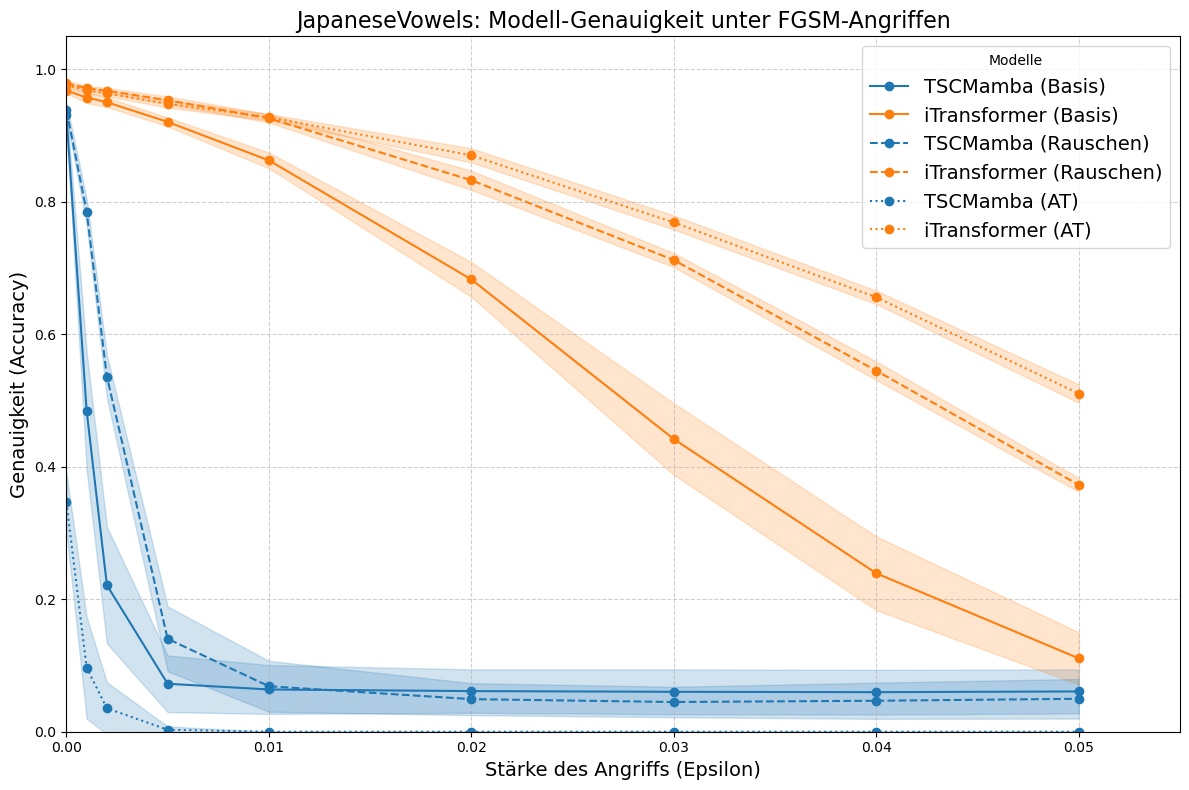

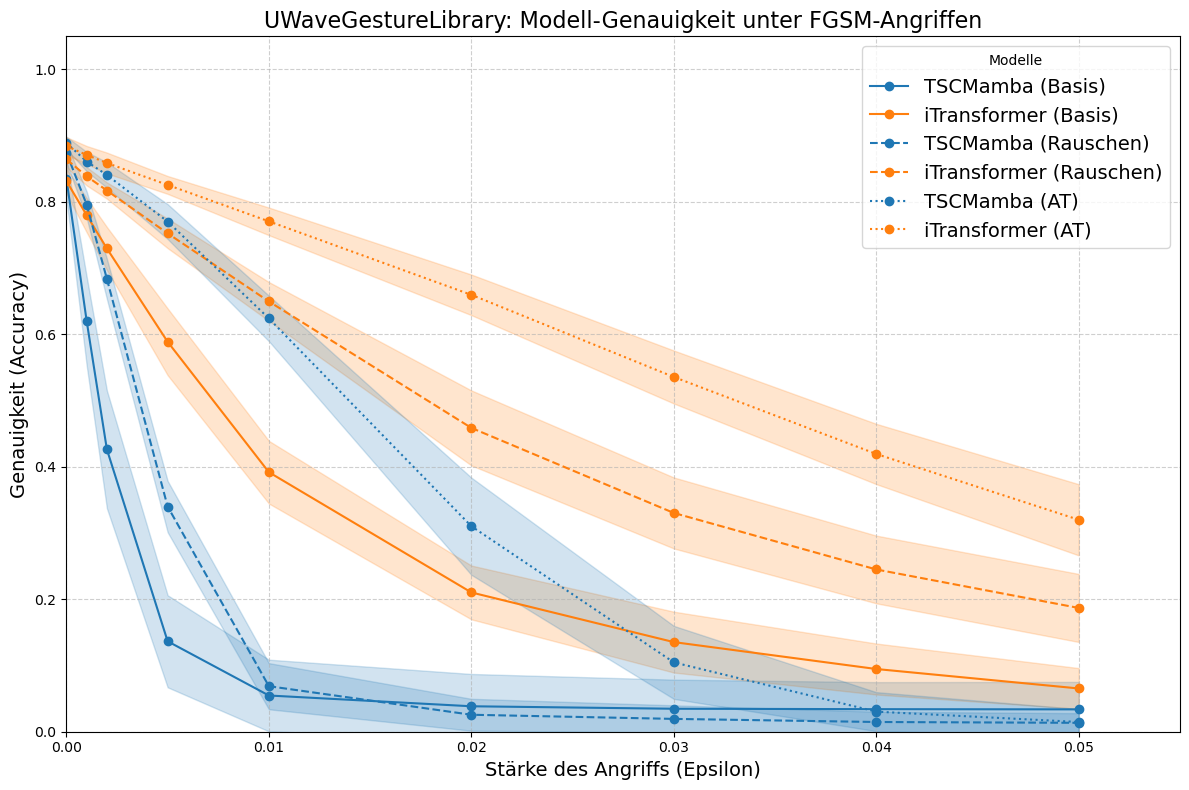

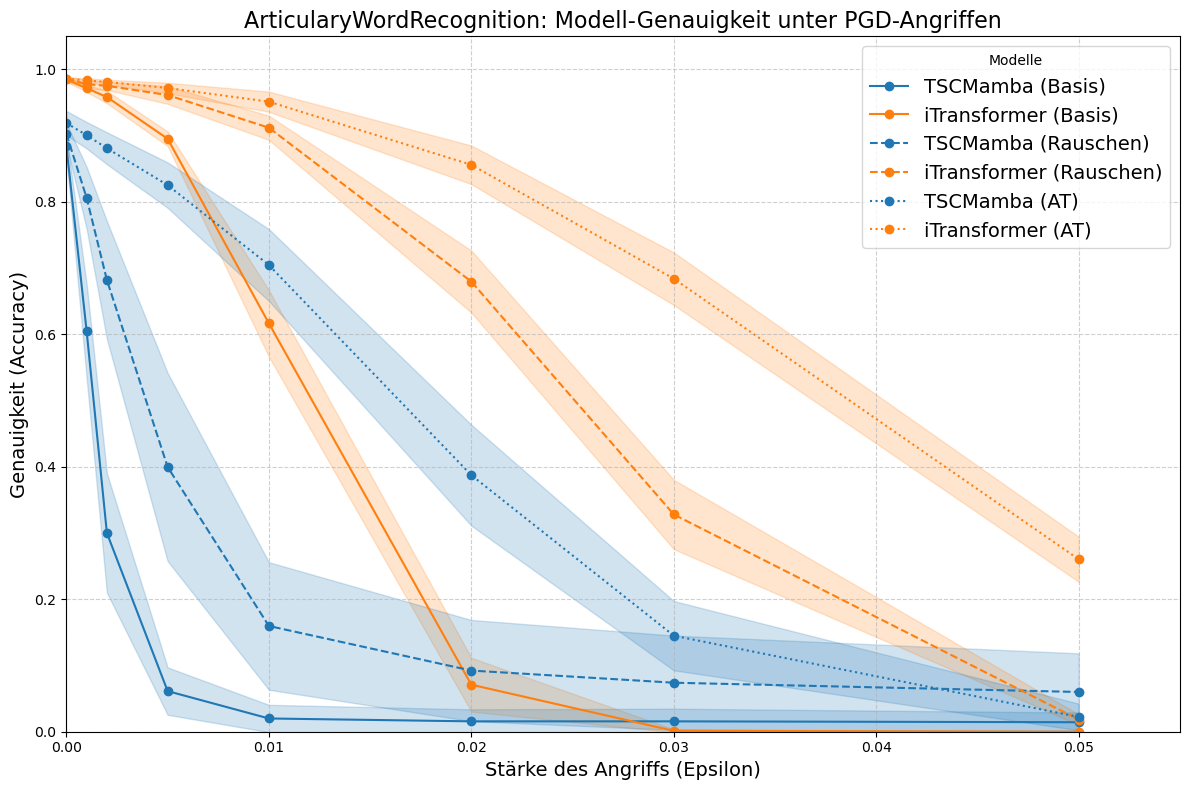

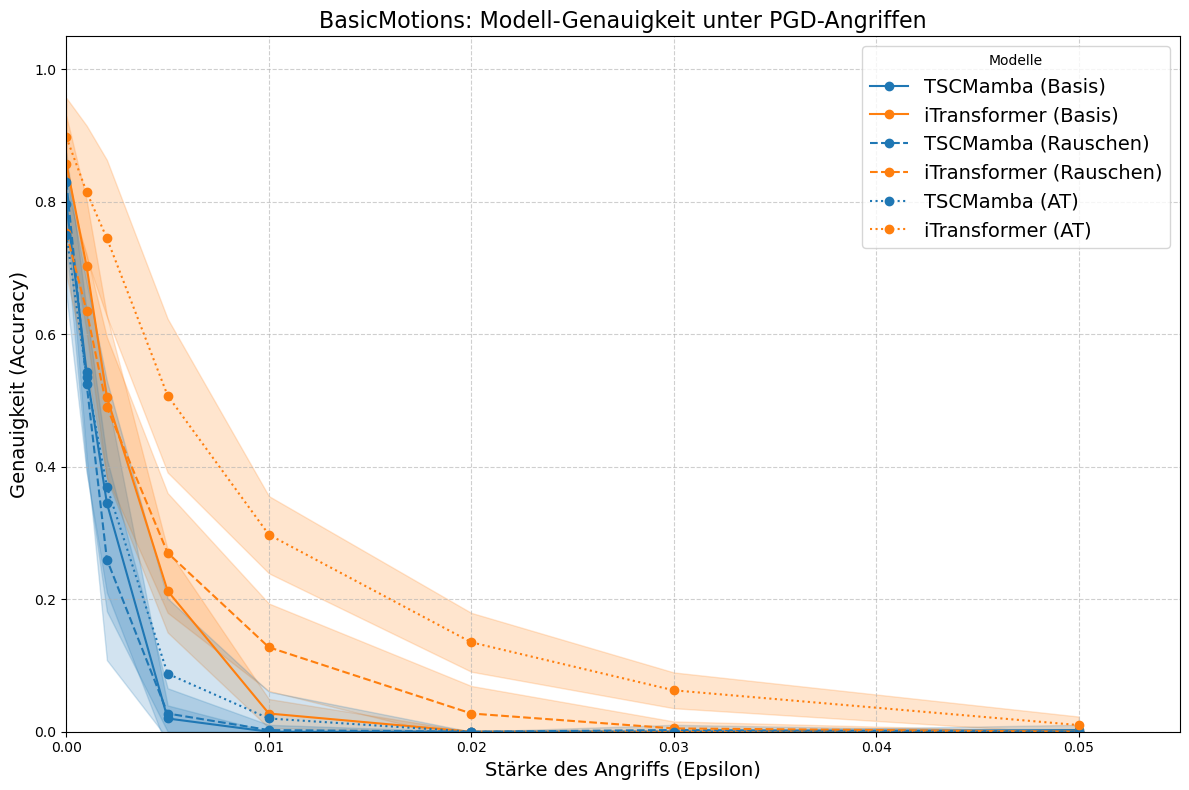

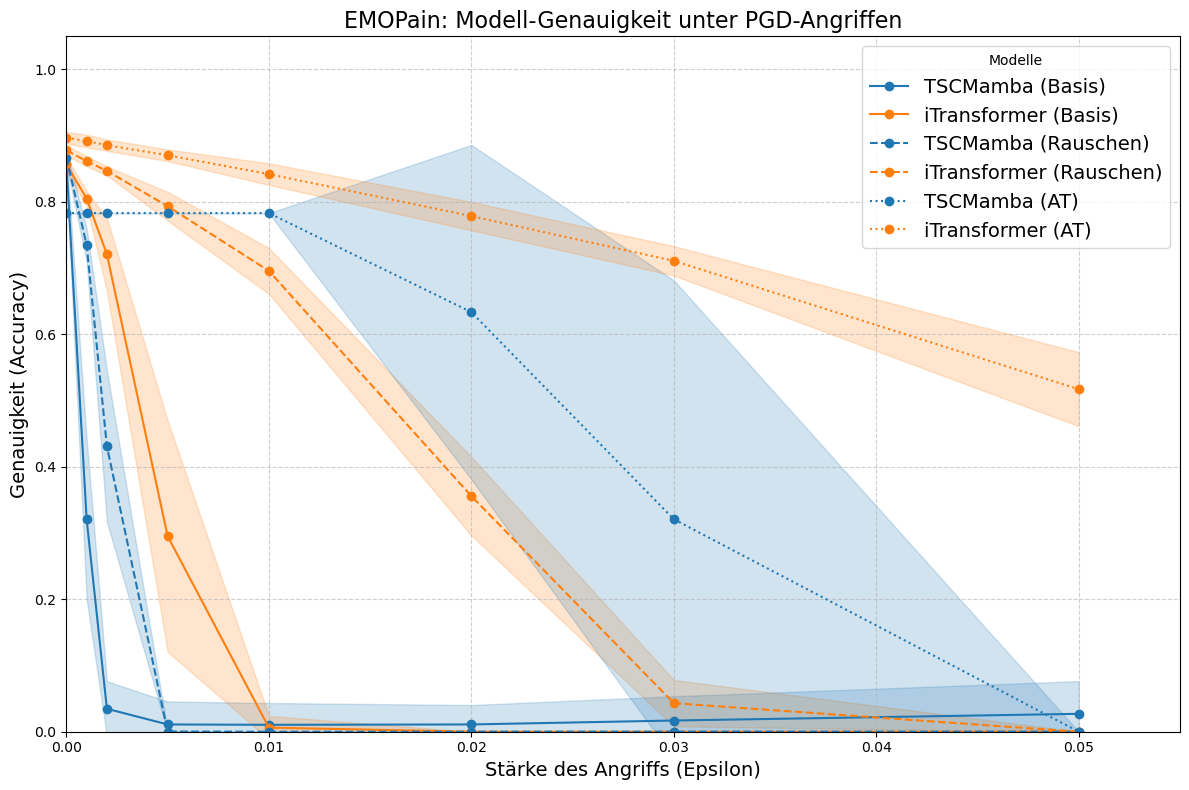

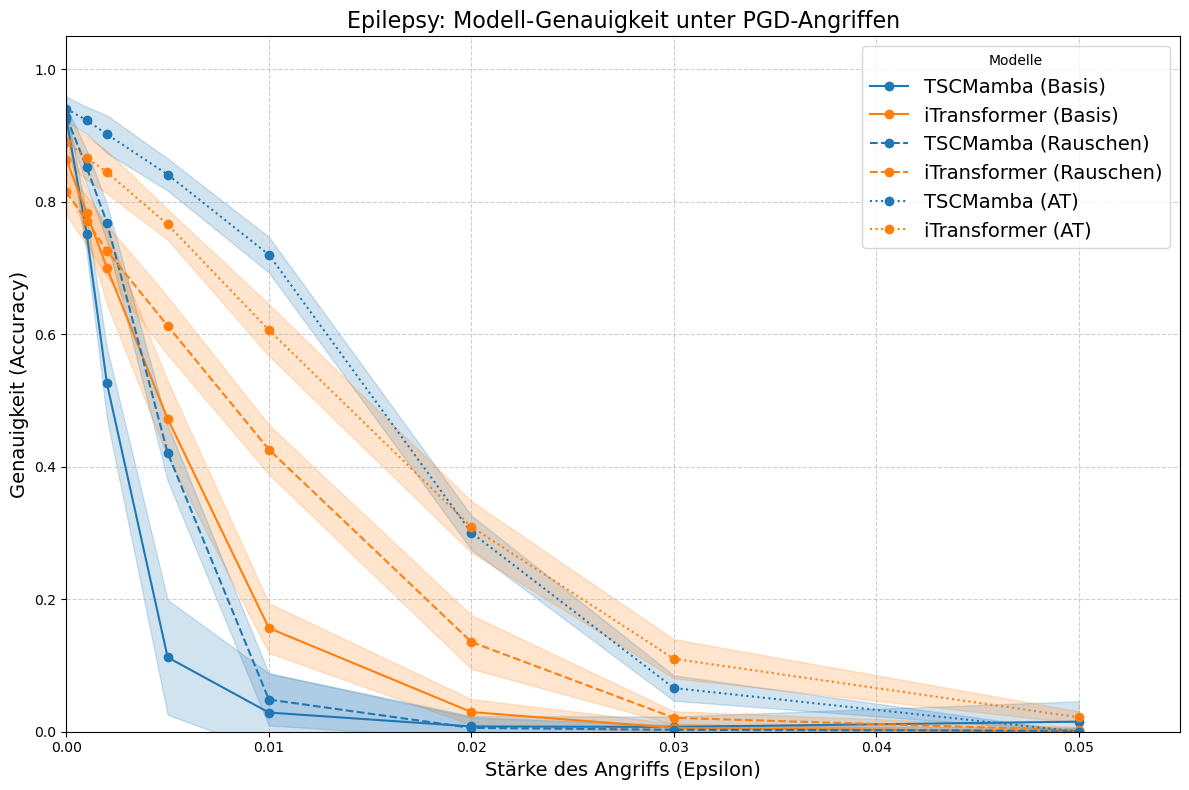

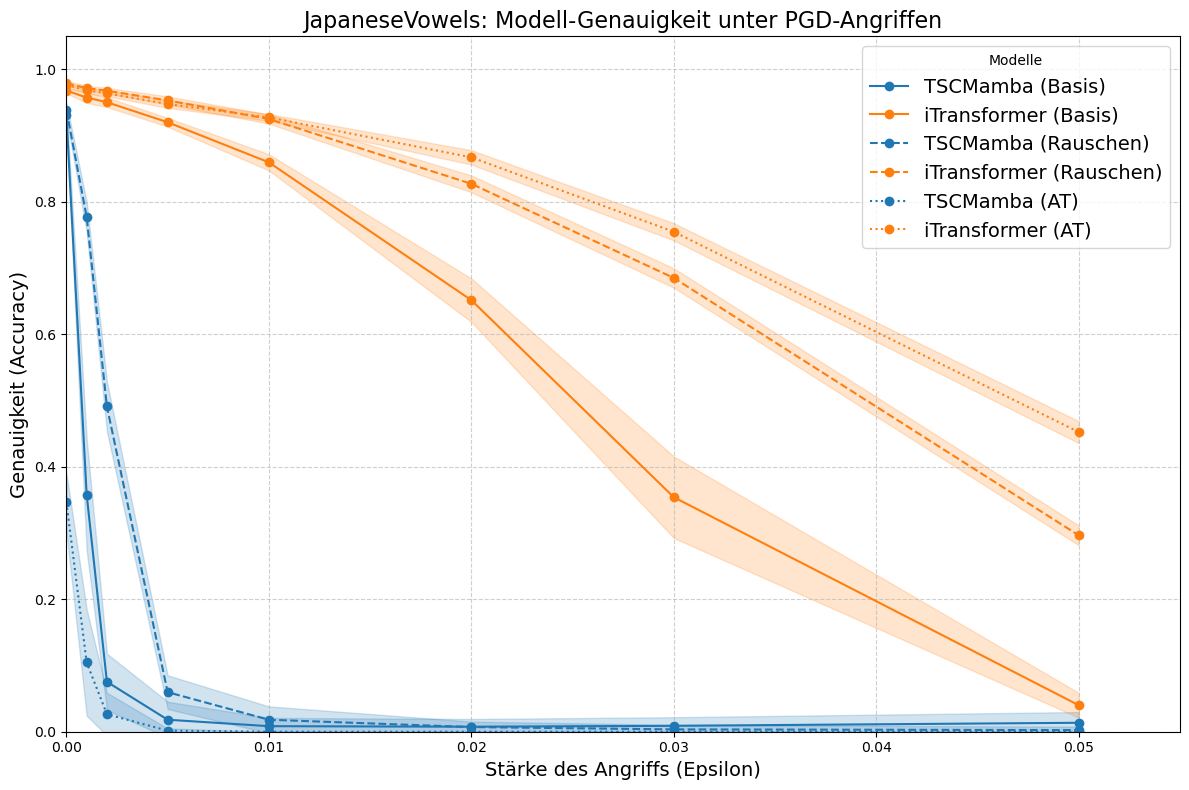

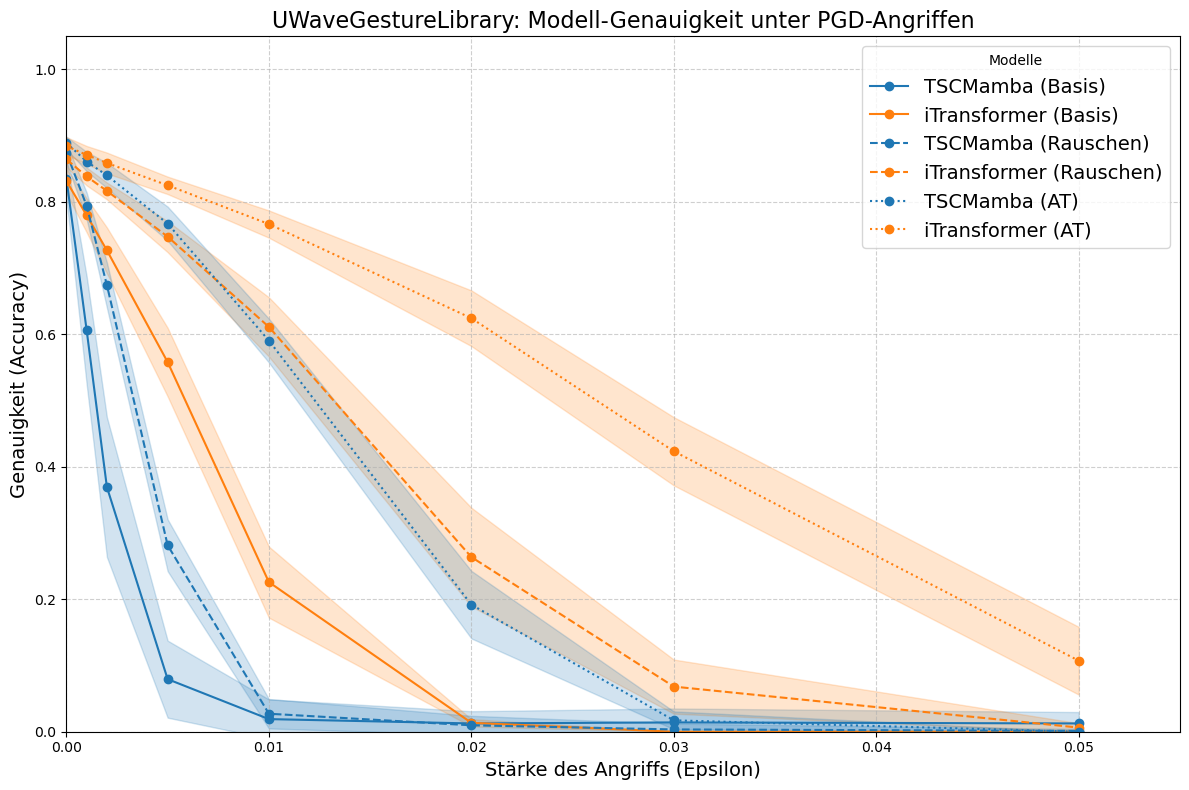

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def create_figures(attack: str, steps: int = 10):

    for dataset in ["ArticularyWordRecognition", "BasicMotions", "EMOPain", "Epilepsy", "JapaneseVowels", "UWaveGestureLibrary"]:
        input_file = f"Results/{dataset}.csv"
        if attack == "PGD":
            output_file = f"Results/{attack}_angriff_plot_{dataset}_{steps}_steps.pdf"
        else:
            output_file = f"Results/{attack}_angriff_plot_{dataset}.pdf"
        
        # 1. Daten einlesen
        df = pd.read_csv(input_file)
        df_to_plot = df.head(6)

        # 2. Daten und Stile vorbereiten
        epsilon_values = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
        if attack == "PGD":
            epsilon_values = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]
            mean_cols = [
                'Acc_Clean_No_Attack_mean', f'Acc_PGD_eps0001__{steps}_steps_mean', f'Acc_PGD_eps0002__{steps}_steps_mean',
                f'Acc_PGD_eps0005__{steps}_steps_mean', f'Acc_PGD_eps001__{steps}_steps_mean', f'Acc_PGD_eps002__{steps}_steps_mean',
                f'Acc_PGD_eps003__{steps}_steps_mean', f'Acc_PGD_eps005__{steps}_steps_mean'
            ]
        else:
            mean_cols = [
                'Acc_Clean_No_Attack_mean', 'Acc_FGSM_eps0001_mean', 'Acc_FGSM_eps0002_mean',
                'Acc_FGSM_eps0005_mean', 'Acc_FGSM_eps001_mean', 'Acc_FGSM_eps002_mean',
                'Acc_FGSM_eps003_mean', 'Acc_FGSM_eps004_mean', 'Acc_FGSM_eps005_mean'
            ]
        std_cols = [col.replace('_mean', '_std') for col in mean_cols]

        # --- NEU: Definition von Farben und Linienstilen ---
        model_colors = {
            'TSCMamba': 'C0',  # Standard-Blau von Matplotlib
            'iTransformer': 'C1'  # Standard-Orange von Matplotlib
        }
        linestyles = ['-', '--', ':']  # durchgezogen, gestrichelt, gepunktet

        model_counters = {model: 0 for model in df_to_plot['Model'].unique()}
        # ----------------------------------------------------

        # 3. Den Plot erstellen
        fig, ax = plt.subplots(figsize=(12, 8))

        for index, row in df_to_plot.iterrows():
            accuracies = row[mean_cols].values.astype(float)
            stds = row[std_cols].values.astype(float)
            
            # --- NEU: Dynamische Stil-Zuweisung ---
            model_name = row['Model']
            
            color = model_colors[model_name]
            style_index = model_counters[model_name] % len(linestyles)
            linestyle = linestyles[style_index]
            
            model_counters[model_name] += 1
            # --------------------------------------------
            if index < 2:
                defense = "Basis"
            elif index < 4:
                defense = "Rauschen"
            else:
                defense = "AT"

            label = f"{row['Model']} ({defense})"

            # Linie mit dem zugewiesenen Stil und der Farbe plotten
            ax.plot(epsilon_values, accuracies, marker='o', linestyle=linestyle, label=label, color=color)
            
            # Varianzbereich mit der passenden Farbe hinzufügen
            ax.fill_between(
                epsilon_values, 
                accuracies - stds, 
                accuracies + stds, 
                alpha=0.2,
                color=color
            )
        
        # 4. Den Plot verschönern
        ax.set_title(f'{dataset}: Modell-Genauigkeit unter {attack}-Angriffen', fontsize=16)
        ax.set_xlabel('Stärke des Angriffs (Epsilon)', fontsize=14)
        ax.set_ylabel('Genauigkeit (Accuracy)', fontsize=14)
        ax.legend(title='Modelle', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylim(0, 1.05)
        ax.set_xlim(left=0, right=0.055)

        plt.tight_layout()  # Sorgt für eine gute Anordnung

        # Speichert die Abbildung als PDF-Datei

        os.makedirs('Results', exist_ok=True)  # Sicherstellen, dass der Ordner existiert
        plt.savefig(output_file)


create_figures("FGSM")
create_figures("PGD", steps=10)
#create_figures("PGD", steps=20)

In [7]:
def apply_t_test(first, second):
    # Der eigentliche t-Test - eine einzige Zeile Code!
    # Wir verwenden den t-Test für unabhängige Stichproben (independent samples)
    t_statistic, p_value = stats.ttest_ind(first, second)

    # Die automatisierte Auswertung
    alpha = 0.05

    print(f"Durchschnitt (ohne AT): {np.mean(first):.2f}%")
    print(f"Durchschnitt (mit AT):  {np.mean(second):.2f}%")
    print(f"p-Wert des t-Tests: {p_value}")

    if p_value < alpha:
        print("\nErgebnis: Der Unterschied ist statistisch signifikant.")
        print("Interpretation: Die Verbesserung der Genauigkeit durch AT ist sehr wahrscheinlich kein Zufall.")
    else:
        print("\nErgebnis: Der Unterschied ist nicht statistisch signifikant.")
        print("Interpretation: Wir haben keinen ausreichenden statistischen Beleg, dass AT die Genauigkeit verbessert.")

accuracy_abfall_tscmamba = [69.63, 75.75, 84.09, 67.90, 85.81, 69.87] 
accuracy_abfall_itransformer  = [8.43, 61.50, 49.32, 36.38, 4.73, 24.28]

apply_t_test(accuracy_abfall_tscmamba, accuracy_abfall_itransformer)

accuracy_abfall_tscmamba_pgd = [82.27, 77.75, 84.62, 81.31, 91.24, 75.59]
accuracy_abfall_itransformer_pgd = [8.97, 64.50, 56.14, 39.13, 4.78, 27.35]

apply_t_test(accuracy_abfall_tscmamba_pgd, accuracy_abfall_itransformer_pgd)

rauschen_fgsm_tsc = [52.07, 4.25, 2.25, 47.25, 14.03, 34]
training_fgsm_tsc = [82.67, 10.50, 78.31, 84.42, 48.57, 77.03]

apply_t_test(rauschen_fgsm_tsc, training_fgsm_tsc)

tscmamba_acc_noise_pgd = [39.97, 2.75, 0.03, 42.10, 5.97, 28.16]
tscmamba_acc_at_pgd = [82.53, 8.75, 78.31, 84.13, 43.68, 76.72] # JV-Wert korrigiert!
apply_t_test(tscmamba_acc_at_pgd, tscmamba_acc_noise_pgd)


# --- Hypothese 3: Ist AT für iTransformer signifikant wirksamer als Rauschen? ---
# Metrik: Finale Genauigkeit unter PGD-Angriff.
# Daten aus Tabelle 7.2
itransformer_acc_noise_pgd = [96.13, 27.00, 79.35, 61.30, 95.32, 74.75]
itransformer_acc_at_pgd = [97.20, 50.75, 87.04, 76.59, 94.78, 82.50]
apply_t_test(itransformer_acc_at_pgd, itransformer_acc_noise_pgd)

# Gruppe C: Profit durch Rauschen (Spalte iTF P(N), Zeilen PGD)
# AWR, BM, EMO, EPI, JV, UWave
itransformer_profit_noise = [
    6.60,   # AWR
    5.75,   # BM
    49.83,  # EMO
    14.05,  # EPI
    3.29,   # JV
    18.94   # UWave
]

# Gruppe D: Profit durch Adversarielles Training (Spalte iTF P(AT), Zeilen PGD)
# AWR, BM, EMO, EPI, JV, UWave
itransformer_profit = [
    7.67,   # AWR
    29.50,  # BM
    57.52,  # EMO
    29.34,  # EPI
    2.75,   # JV
    26.69   # UWave
]


apply_t_test(itransformer_profit_noise, itransformer_profit)

tscmamba_profit_noise_pgd = [
    33.84,  # AWR
    0.75,   # BM
    -1.07,  # EMO
    30.87,  # EPI
    4.16,   # JV
    20.22   # UWave
]

# Gruppe B: Profit durch Adversarielles Training (Spalte TSCM P(AT), Zeilen PGD)
# AWR, BM, EMO, EPI, JV (korrigiert!), UWave
tscmamba_profit_at_pgd = [
    76.40,  # AWR
    6.75,   # BM
    77.21,  # EMO
    72.90,  # EPI
    41.87,  # JV (korrigierter Wert für reduziertes AT)
    68.78   # UWave
]

apply_t_test(tscmamba_profit_at_pgd, tscmamba_profit_noise_pgd)



Durchschnitt (ohne AT): 75.51%
Durchschnitt (mit AT):  30.77%
p-Wert des t-Tests: 0.0009874073064583765

Ergebnis: Der Unterschied ist statistisch signifikant.
Interpretation: Die Verbesserung der Genauigkeit durch AT ist sehr wahrscheinlich kein Zufall.
Durchschnitt (ohne AT): 82.13%
Durchschnitt (mit AT):  33.48%
p-Wert des t-Tests: 0.0007575580084276765

Ergebnis: Der Unterschied ist statistisch signifikant.
Interpretation: Die Verbesserung der Genauigkeit durch AT ist sehr wahrscheinlich kein Zufall.
Durchschnitt (ohne AT): 25.64%
Durchschnitt (mit AT):  63.58%
p-Wert des t-Tests: 0.028604182559575322

Ergebnis: Der Unterschied ist statistisch signifikant.
Interpretation: Die Verbesserung der Genauigkeit durch AT ist sehr wahrscheinlich kein Zufall.
Durchschnitt (ohne AT): 62.35%
Durchschnitt (mit AT):  19.83%
p-Wert des t-Tests: 0.015595809445983872

Ergebnis: Der Unterschied ist statistisch signifikant.
Interpretation: Die Verbesserung der Genauigkeit durch AT ist sehr wahrschein

In [2]:
import scipy.stats as stats

# Die Genauigkeitsdaten für TSCMamba unter PGD-Angriff
genauigkeit_ohne_AT = [6.13, 2.00, 1.10, 11.23, 1.81, 7.94]
genauigkeit_mit_AT = [82.53, 8.75, 78.31, 84.13, 43.68, 76.72]

# Durchführung des gepaarten, einseitigen t-Tests
# 'alternative="greater"' prüft, ob der Mittelwert von 'genauigkeit_mit_AT' 
# signifikant GRÖSSER ist als der von 'genauigkeit_ohne_AT'.
t_statistic, p_value = stats.ttest_rel(genauigkeit_mit_AT, genauigkeit_ohne_AT, alternative='greater')

print(f"T-Statistik: {t_statistic:.4f}")
print(f"P-Wert: {p_value:.4f}")

# Entscheidung basierend auf dem p-Wert (Signifikanzniveau α = 0.05)
if p_value < 0.05:
    print("Das Ergebnis ist statistisch signifikant. Wir können die Nullhypothese ablehnen.")
else:
    print("Das Ergebnis ist nicht statistisch signifikant.")

T-Statistik: 5.0081
P-Wert: 0.0020
Das Ergebnis ist statistisch signifikant. Wir können die Nullhypothese ablehnen.


In [5]:
import scipy.stats as stats

# Die Genauigkeitsdaten für TSCMamba unter PGD-Angriff
genauigkeit_ohne_AT = [89.53, 21.25, 29.52, 47.25, 92.03, 55.81]
genauigkeit_mit_AT = [97.2, 50.75, 87.04, 76.59, 94.78, 82.5]

# Durchführung des gepaarten, einseitigen t-Tests
# 'alternative="greater"' prüft, ob der Mittelwert von 'genauigkeit_mit_AT' 
# signifikant GRÖSSER ist als der von 'genauigkeit_ohne_AT'.
t_statistic, p_value = stats.ttest_rel(genauigkeit_mit_AT, genauigkeit_ohne_AT, alternative='greater')

print(f"T-Statistik: {t_statistic:.4f}")
print(f"P-Wert: {p_value:.4f}")

# Entscheidung basierend auf dem p-Wert (Signifikanzniveau α = 0.05)
if p_value < 0.05:
    print("Das Ergebnis ist statistisch signifikant. Wir können die Nullhypothese ablehnen.")
else:
    print("Das Ergebnis ist nicht statistisch signifikant.")

T-Statistik: 3.2201
P-Wert: 0.0117
Das Ergebnis ist statistisch signifikant. Wir können die Nullhypothese ablehnen.
